In [1]:
import numpy as np
import networkx as nx
from networkx import grid_graph
from scipy import linalg
from scipy.special import sici
import math
from matplotlib import pyplot as plt
from dppy.finite_dpps import FiniteDPP
from dppy.utils import example_eval_L_linear
from scipy.integrate import quad, dblquad, nquad
from scipy.special import airy
from tqdm.notebook import tqdm, trange
from time import sleep
from os import system
from IPython.display import clear_output
import itertools
from p_tqdm import p_map


# Poulson Algorithm 1

In [2]:
def sampling_algorithm_1(K):
    
    n = len(K)
    
    sample = []
    A = K.copy()

    for j in range(n):

        if np.random.rand() < A[j][j]:
            sample.append(j)
        else:
            A[j, j] -= 1

        A[j+1:, j] /= A[j, j]
        A[j+1:, j+1:] -= np.outer(A[j+1:, j], A[j, j+1:])

    return sample, A

# Sine Kernel Projection

In [ ]:
n = 500

#algorithm = "Poulson"
algorithm = "DPPy"

def Si(x):
    try: 
        upper = sici(x)[0]
    except:
        upper = sici(x)
    return upper
        
def integral_Si(x):
    return math.cos(x) + x*Si(x)

def compute_sine_kernel_entry(a,b,c,d):
    return (integral_Si(math.pi*(c-b))-integral_Si(math.pi*(c-a)) - (integral_Si(math.pi*(d-b))- integral_Si(math.pi*(d-a))))/((math.pi**2)*(b-a)*(d-c))

r =[-20,20]
slice_size = (max(r)-min(r))/n

# determine # of slices 
n_slices = int((max(r)-min(r))/slice_size +1)

# split the range
x_part = np.linspace(*r, n_slices)
y_part = np.linspace(*r, n_slices)

kernel = np.array([[compute_sine_kernel_entry(x_part[i],x_part[i+1],y_part[j],y_part[j+1]) for i in range(len(x_part)-1)] for j in range(len(y_part)-1)])
kernel = kernel*(slice_size)


eigenvalues, eigenvectors = np.linalg.eig(kernel)

print("Kernel Trace: " + str(np.trace(kernel)))
print("Max Eigenvalue: " + str(max(eigenvalues.real)))
print("Min Eigenvalue: " + str(min(eigenvalues.real)))


samples = None

if algorithm == "Poulson":
    samples,_ = sampling_algorithm_1(kernel)
elif algorithm == "DPPy":
    DPP = FiniteDPP('correlation', **{'K': kernel})
    DPP.sample_exact()
    samples = DPP.list_of_samples[0]

plt.matshow(np.array(kernel))
plt.colorbar()
plt.title("Discretized Sine Kernel")
plt.show()

fig = plt.figure(figsize=(10,1))
plt.scatter(np.array(samples)/n*(max(airy_window)-min(airy_window))-(max(r)-min(r))/2,np.zeros(len(samples)))
print(len(samples))

# Airy Kernel Projection


In [ ]:
n = 100
samples = 0
airy_window =[-20,10]
slice_size = (max(airy_window)-min(airy_window))/n

def compute_airy_kernel_entry(params):
    a,b,c,d = params
    
    if (a==c):
        a+= 0.00000000001
    if (c==b):
        b-= 0.00000000001
            
    return dblquad(lambda x, y: (airy(x)[0]*airy(y)[1] - airy(x)[1]*airy(y)[0])/(x-y), a,b,c,d)[0]/((slice_size)**2)


# determine # of slices 
n_slices = int((max(r)-min(r))/slice_size +1)

# split the range
x_part = np.linspace(*airy_window, n_slices)
y_part = np.linspace(*airy_window, n_slices)

inputs = [(x_part[i],x_part[i+1],y_part[j],y_part[j+1]) for i in range(len(x_part)-1) for j in range(len(y_part)-1)]
num_tasks = len(inputs)

airy_kernel = p_map(compute_airy_kernel_entry,inputs, num_cpus=4)

airy_kernel = np.array(airy_kernel).reshape(len(x_part)-1,len(y_part)-1)

#kernel = np.array([[compute_airy_kernel_entry(x_part[i],x_part[i+1],y_part[j],y_part[j+1]) for i in range(len(x_part)-1)] for j in range(len(y_part)-1)])
airy_kernel = airy_kernel*(slice_size)


  0%|          | 0/110889 [00:00<?, ?it/s]

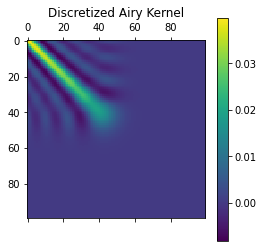

Kernel Trace: 1.3334134514666152
Max Eigenvalue: 0.1999319007566234
Min Eigenvalue: -1.6104624337292784e-11
1


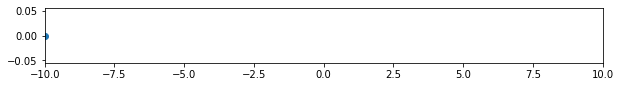

In [24]:
#algorithm = "Poulson"
algorithm = "DPPy"

plt.matshow(np.array(airy_kernel))
plt.colorbar()
plt.title("Discretized Airy Kernel")
plt.show()


eigenvalues, eigenvectors = np.linalg.eig(airy_kernel)

print("Kernel Trace: " + str(np.trace(airy_kernel)))
print("Max Eigenvalue: " + str(max(eigenvalues.real)))
print("Min Eigenvalue: " + str(min(eigenvalues.real)))

samples = None

if algorithm == "Poulson":
    samples,_ = sampling_algorithm_1(airy_kernel)
elif algorithm == "DPPy":
    DPP = FiniteDPP('correlation', **{'K': airy_kernel})
    DPP.sample_exact()
    samples = DPP.list_of_samples[0]


fig = plt.figure(figsize=(10,1))
plt.scatter(np.array(samples)/n*(max(r)-min(r))-(max(r)-min(r))/2,np.zeros(len(samples)))
plt.xlim(airy_window[0], airy_window[1])
print(len(samples))